# Travaux Pratiques : Introduction Pédagogique aux GANs (MLP-GAN)

## Objectifs Pédagogiques de l'Atelier

1.  **Conceptualisation :** Comprendre le principe du **jeu antagoniste** et l'analogie du Faux-Monnayeur vs. Détective.

2.  **Théorie :** Décortiquer la fonction de coût **Minimax** qui régit l'apprentissage des GANs.

3.  **Implémentation Basique :** Mettre en œuvre un GAN simple (basé sur des couches linéaires/MLP) avec PyTorch sur la base Fashion-MNIST.

4.  **Analyse :** Comprendre les défis liés à la stabilité de l'entraînement des GANs.

---
## I. Introduction Conceptuelle

Les **Generative Adversarial Networks** (Réseaux Génératifs Antagonistes) sont composés de deux réseaux qui s'affrontent dans un jeu à somme nulle : le **Générateur (G)** et le **Discriminateur (D)**.

| Composant | Rôle Analogue | Rôle Technique | Objectif |
| :--- | :--- | :--- | :--- |
| **Générateur (G)** | Le Faux-Monnayeur | Prend un bruit aléatoire $\mathbf{z}$ et crée $\mathbf{x}_{\text{faux}}$. | Tromper $D$ pour que $D$ classe les faux comme VRAIS (1). |
| **Discriminateur (D)** | Le Détective | Classifie une image comme VRAIE (1) ou FAUSSE (0). | Identifier parfaitement la provenance de l'image (maximiser l'exactitude). |


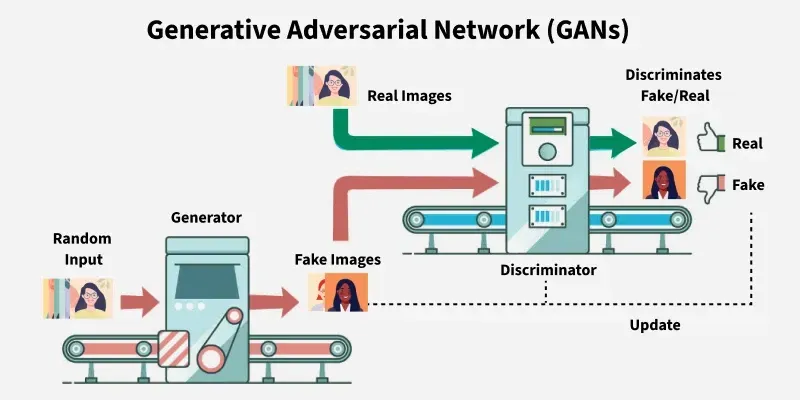

### Comment fonctionne un GAN ?


#### 1. Première étape : le Générateur entre en scène

Le générateur commence avec un **vecteur de bruit aléatoire** (une série de nombres au hasard).
À partir de ce bruit, il essaie de créer une donnée **fausse mais réaliste** — par exemple, une image générée.
Les différentes couches du générateur transforment progressivement le bruit en quelque chose qui ressemble à de vraies données.

---

#### 2. Tour du Discriminateur

Le discriminateur reçoit deux types de données :

* Des **échantillons réels** issus du vrai jeu de données.
* Des **échantillons générés** par le générateur.

Son rôle est de dire si chaque donnée est **réelle ou fausse**.
Il renvoie une **probabilité entre 0 et 1** :

* Proche de 1 : donnée probablement réelle.
* Proche de 0 : donnée probablement générée.

---

#### 3. Apprentissage Adversarial

* Si le discriminateur détecte correctement les vraies et fausses données, il devient meilleur à son travail.
* Si le générateur parvient à le tromper avec une donnée très réaliste, il gagne des points — tandis que le discriminateur est pénalisé pour s’être trompé.

---

#### 4. Amélioration du Générateur

Chaque fois que le générateur réussit à tromper le discriminateur, il apprend à faire **de meilleurs faux**.
Au fil des itérations, il devient capable de générer des données de plus en plus réalistes.

---

#### 5. Adaptation du Discriminateur

Le discriminateur continue aussi à s’améliorer : il met à jour ses paramètres pour **mieux détecter les données générées**.

Cette confrontation permanente pousse les deux réseaux à s’améliorer simultanément.

---

#### 6. Progression de l’Entraînement

À mesure que l’entraînement avance :

* Le générateur devient très bon pour produire des données presque indiscernables des vraies.
* Le discriminateur finit par avoir du mal à dire si une donnée est vraie ou fausse.

Quand le discriminateur **ne peut plus distinguer le vrai du faux**, cela signifie que le GAN est **bien entraîné** 🟢.


###  La Fonction de coût (Minimax Game)

L'entraînement du GAN est formulé comme la recherche d'un **équilibre de Nash** dans le jeu Minimax :

$$\min_G \max_D V(D, G) = \mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log (1 - D(G(\mathbf{z})))]$$

* **$\max_D$ (Maximisation par D) :** Le Discriminateur veut que $D(\mathbf{x})$ (vrai) soit proche de 1 et que $D(G(\mathbf{z}))$ (faux) soit proche de 0. Cela maximise l'expression.
* **$\min_G$ (Minimisation par G) :** Le Générateur veut que $D(G(\mathbf{z}))$ (faux) soit proche de 1 (pour tromper $D$). Cela minimise le second terme de l'expression.

**L'équilibre idéal** est atteint lorsque $D(\mathbf{x}) = D(G(\mathbf{z})) = 0.5$ pour tout $\mathbf{x}$, car $D$ ne peut plus faire la différence.

### Question  (Q1.1)

Si, au début de l'entraînement, le Discriminateur renvoie $D(\mathbf{x}) = 0.9$ pour les vraies images et $D(G(\mathbf{z})) = 0.1$ pour les fausses images, comment cela impacte-t-il l'apprentissage du Générateur $G$ à ce stade ? (Indice : regardez le terme $\log (1 - D(G(\mathbf{z})))$).

---

## II. Préparation et Architecture (MLP-GAN)

Nous utilisons des réseaux de neurones multi-couches (MLP) simples pour démarrer. Les images 28x28 seront mises à plat en vecteurs de 784 dimensions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

# Hyperparamètres
image_size = 28 * 28  # 784
latent_dim = 100       # Dimension du bruit z
batch_size = 128
epochs = 50
lr = 0.0002 # Taux d'apprentissage souvent bas pour la stabilité des GANs

# Chargement des données et aplatissement des images (ToTensor() + normalisation [0, 1])
transform = ToTensor()
train_dataset = FashionMNIST(root='./data/FashionMNIST', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Exécution sur cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 190kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]


### 2.2. Le Générateur (G)

Input : Vecteur de bruit $z$ (`latent_dim`). Output : Vecteur image $\mathbf{x}'$ (`image_size`).

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256), #Vecteur de bruit
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Sigmoid() # Sigmoid pour garantir la sortie [0, 1] (normalisation simple) 
        )

    def forward(self, z):
        return self.model(z)

### 2.3. Le Discriminateur (D)

Input : Vecteur image $x$ (`image_size`). Output : Score scalaire (logit) qui sera transformé en probabilité [0, 1].

In [3]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1) # Sortie finale sans activation
        )

    def forward(self, x):
        return self.model(x)

In [4]:
# Initialisation
G = Generator(latent_dim, image_size).to(device)
D = Discriminator(image_size).to(device)

# Optimiseurs : Le choix d'Adam et des betas=(0.5, 0.999) est standard pour les GANs ça aide la stabilité de l’entraînement GAN.
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss : BCEWithLogitsLoss est recommandé pour la stabilité numérique. Elle inclut Sigmoid.
criterion = nn.BCEWithLogitsLoss()

# Bruit fixe pour suivre la progression de la génération
fixed_noise = torch.randn(64, latent_dim, device=device)

# Fonction utilitaire de visualisation (réutilisée du TP VAE)
def show_grid(grid, title="", figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.title(title)
    # Note: On utilise 'cmap="gray"' car Fashion-MNIST est en niveaux de gris
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap="gray")
    plt.axis("off")
    plt.show()

### Question  (Q2.1)

Observez les taux d'apprentissage. Pourquoi le taux d'apprentissage est-il souvent très bas (ici 0.0002) dans les GANs par rapport à d'autres réseaux (souvent 0.001) ? Quel risque prend-on avec des taux d'apprentissage trop élevés pour $G$ ou $D$ ?

---

## III. Boucle d'Entraînement : L'Alternance Cruciale

L'entraînement s'effectue en deux sous-étapes par batch : d'abord on améliore $D$, puis on améliore $G$. C'est le cœur du jeu antagoniste.

Entraînement GAN:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch  1 | D Loss: 0.6234 | G Loss: 2.9269
Epoch  2 | D Loss: 0.5867 | G Loss: 2.7567
Epoch  3 | D Loss: 0.7612 | G Loss: 1.9148
Epoch  4 | D Loss: 0.7721 | G Loss: 1.8483
Epoch  5 | D Loss: 0.7713 | G Loss: 1.8238


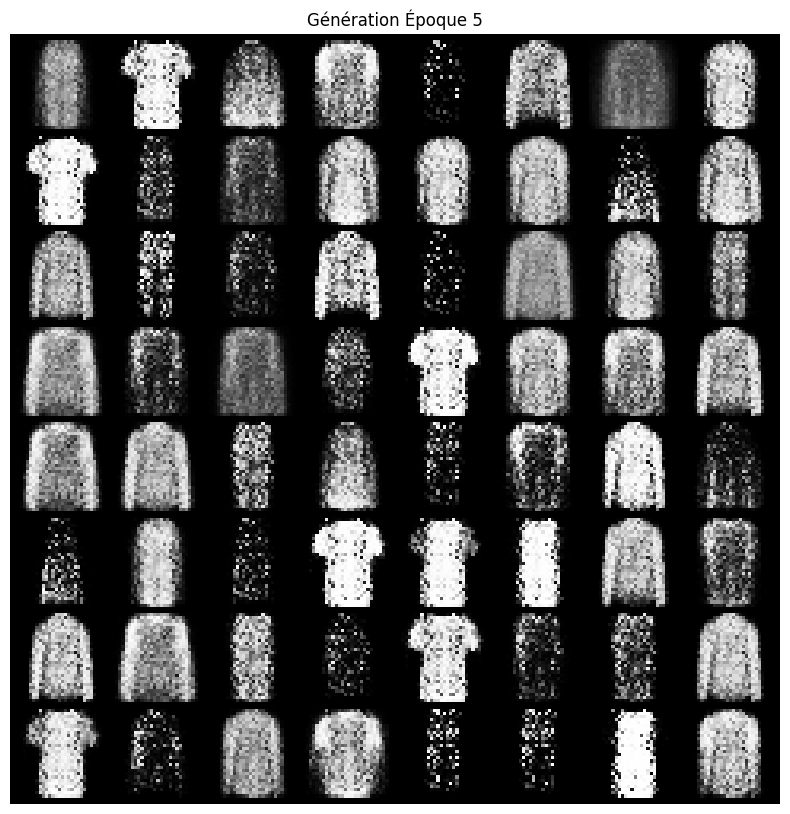

Epoch  6 | D Loss: 0.8477 | G Loss: 1.6749
Epoch  7 | D Loss: 0.9112 | G Loss: 1.5250
Epoch  8 | D Loss: 0.9352 | G Loss: 1.4872
Epoch  9 | D Loss: 0.9285 | G Loss: 1.4726
Epoch 10 | D Loss: 0.9312 | G Loss: 1.4587


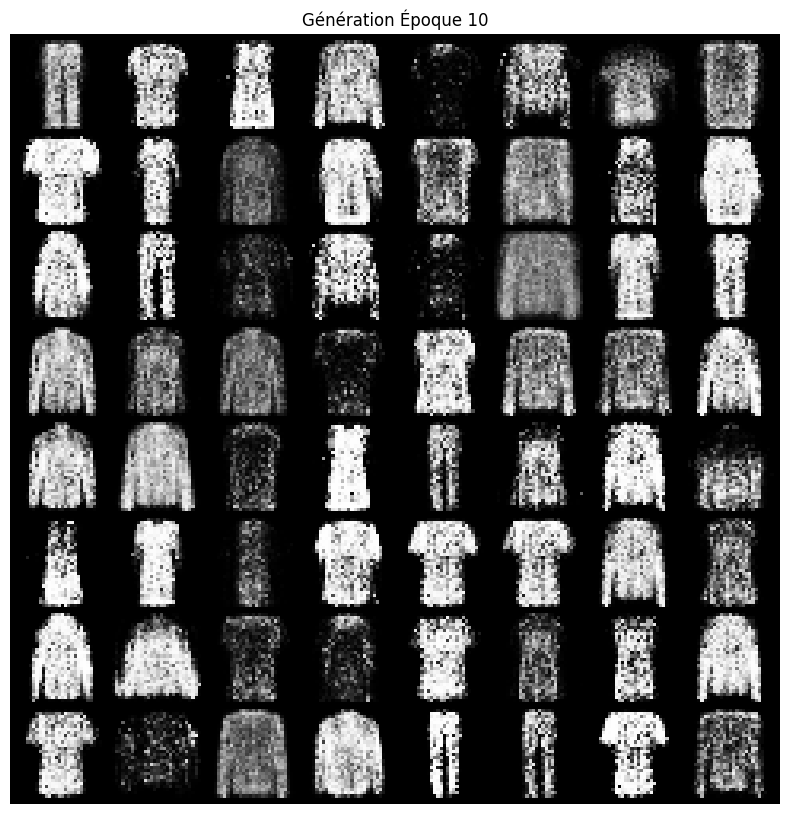

Epoch 11 | D Loss: 1.0022 | G Loss: 1.2968
Epoch 12 | D Loss: 1.0222 | G Loss: 1.2333
Epoch 13 | D Loss: 1.0232 | G Loss: 1.2427
Epoch 14 | D Loss: 1.0185 | G Loss: 1.2597
Epoch 15 | D Loss: 1.0221 | G Loss: 1.2494


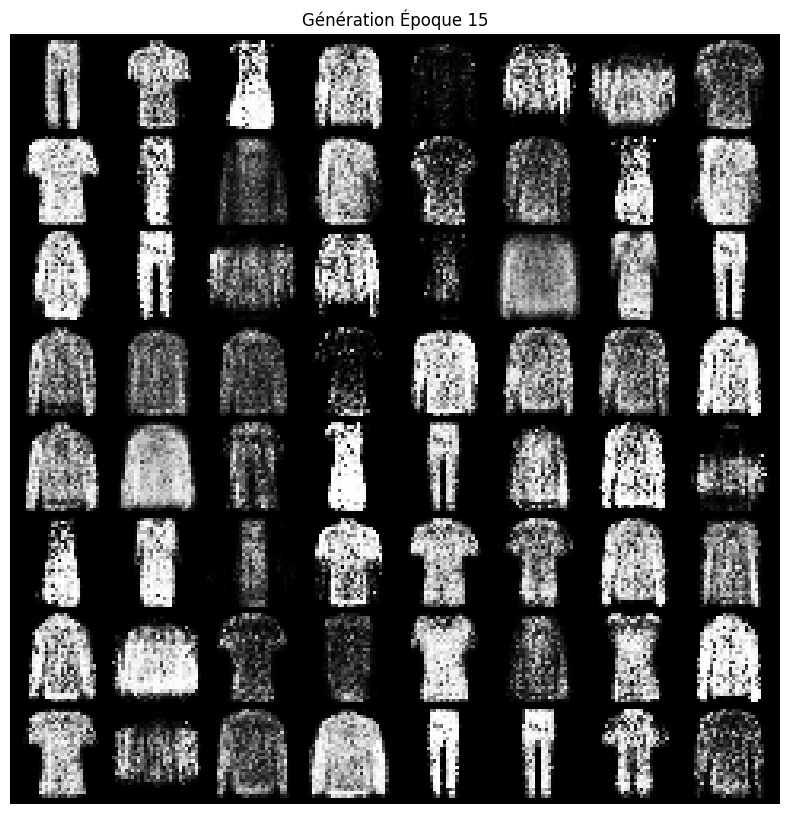

Epoch 16 | D Loss: 1.0438 | G Loss: 1.2046
Epoch 17 | D Loss: 1.0645 | G Loss: 1.1988
Epoch 18 | D Loss: 1.0885 | G Loss: 1.1707
Epoch 19 | D Loss: 1.1037 | G Loss: 1.1558
Epoch 20 | D Loss: 1.1293 | G Loss: 1.1270


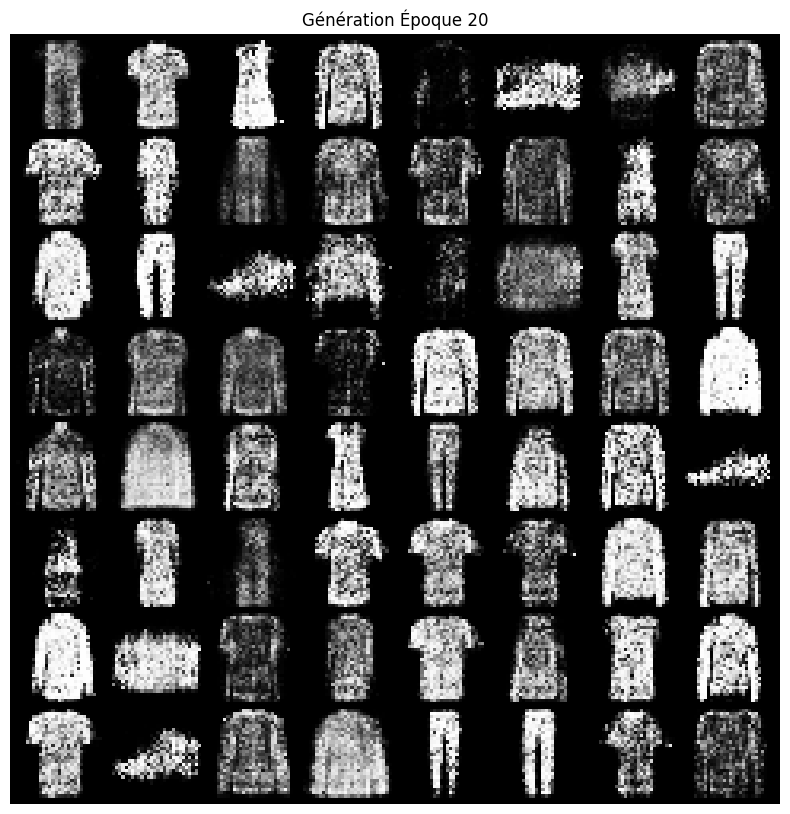

Epoch 21 | D Loss: 1.1322 | G Loss: 1.1355
Epoch 22 | D Loss: 1.1374 | G Loss: 1.1185
Epoch 23 | D Loss: 1.1536 | G Loss: 1.0840
Epoch 24 | D Loss: 1.1650 | G Loss: 1.0835
Epoch 25 | D Loss: 1.1890 | G Loss: 1.0502


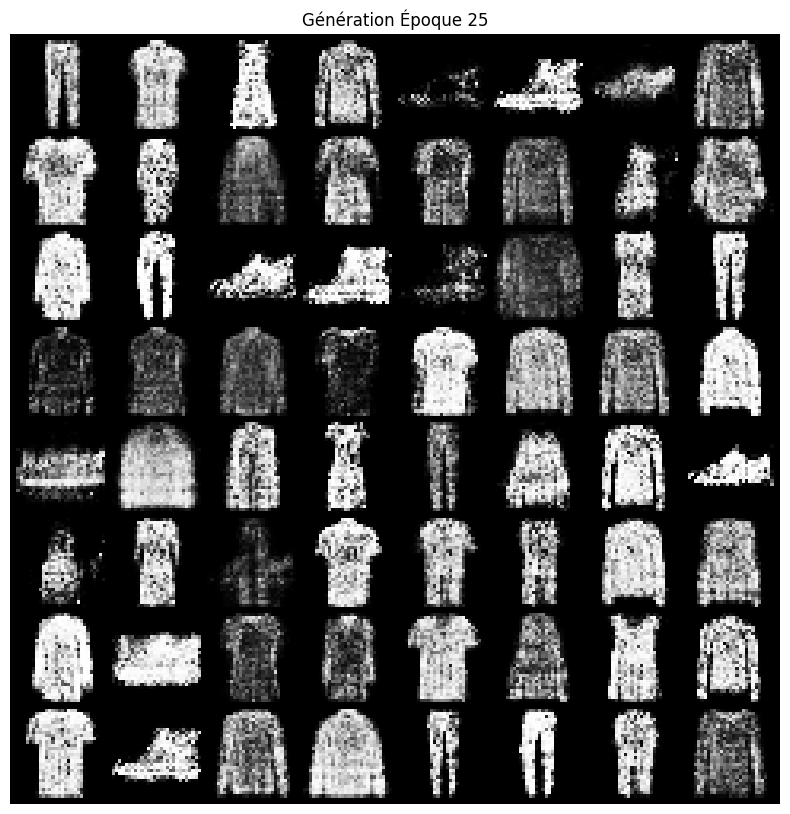

Epoch 26 | D Loss: 1.1957 | G Loss: 1.0419
Epoch 27 | D Loss: 1.1929 | G Loss: 1.0479
Epoch 28 | D Loss: 1.1931 | G Loss: 1.0371
Epoch 29 | D Loss: 1.2015 | G Loss: 1.0354
Epoch 30 | D Loss: 1.2111 | G Loss: 1.0164


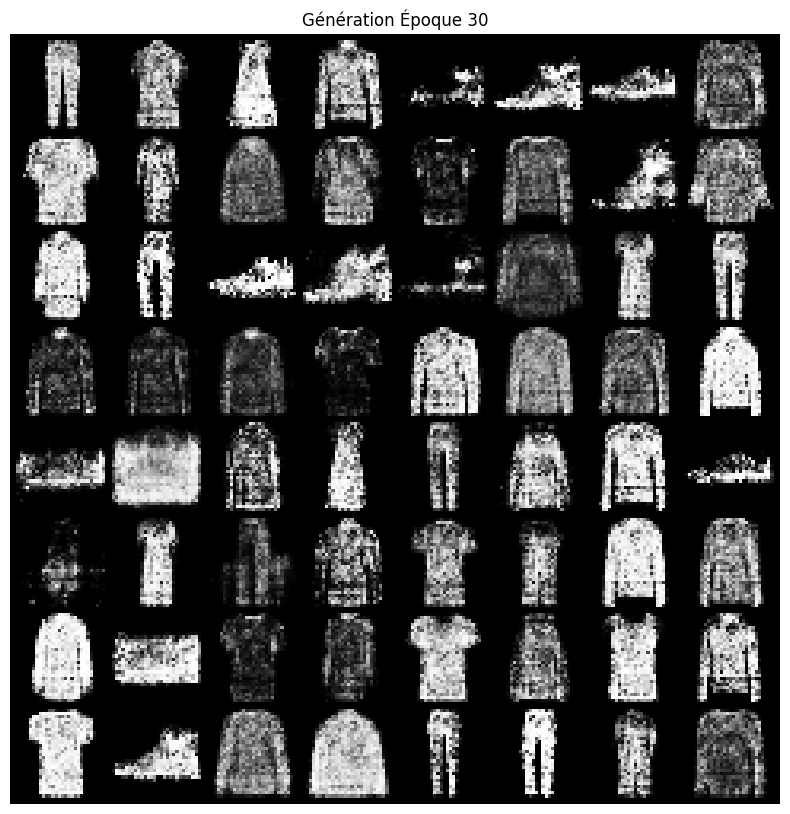

Epoch 31 | D Loss: 1.2185 | G Loss: 1.0100
Epoch 32 | D Loss: 1.2264 | G Loss: 0.9985
Epoch 33 | D Loss: 1.2241 | G Loss: 1.0014
Epoch 34 | D Loss: 1.2295 | G Loss: 0.9931
Epoch 35 | D Loss: 1.2219 | G Loss: 0.9978


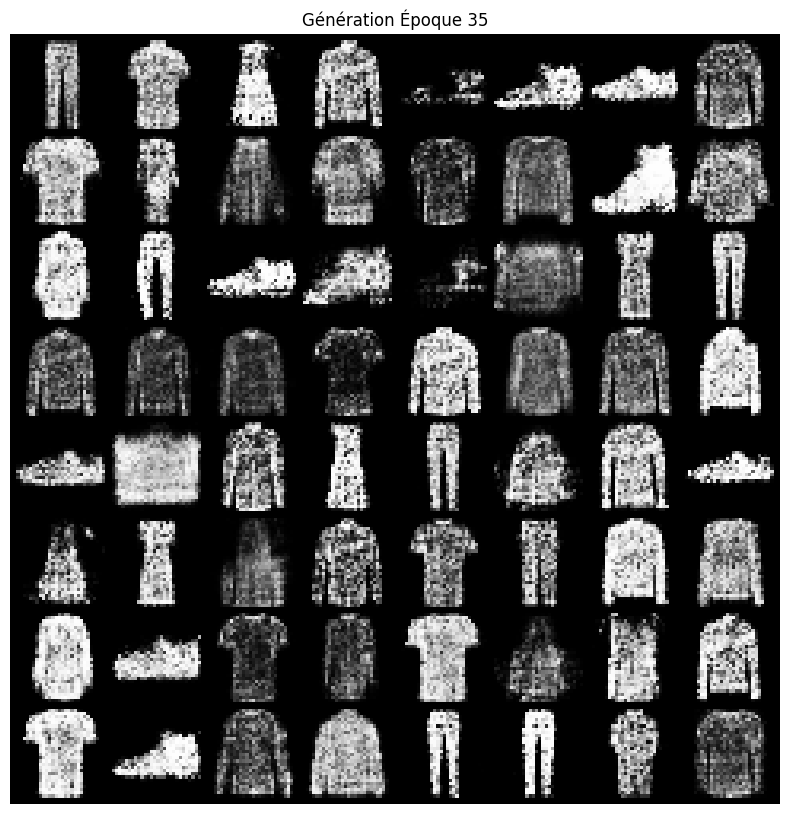

Epoch 36 | D Loss: 1.2319 | G Loss: 0.9847
Epoch 37 | D Loss: 1.2312 | G Loss: 0.9805
Epoch 38 | D Loss: 1.2389 | G Loss: 0.9708
Epoch 39 | D Loss: 1.2380 | G Loss: 0.9763
Epoch 40 | D Loss: 1.2394 | G Loss: 0.9732


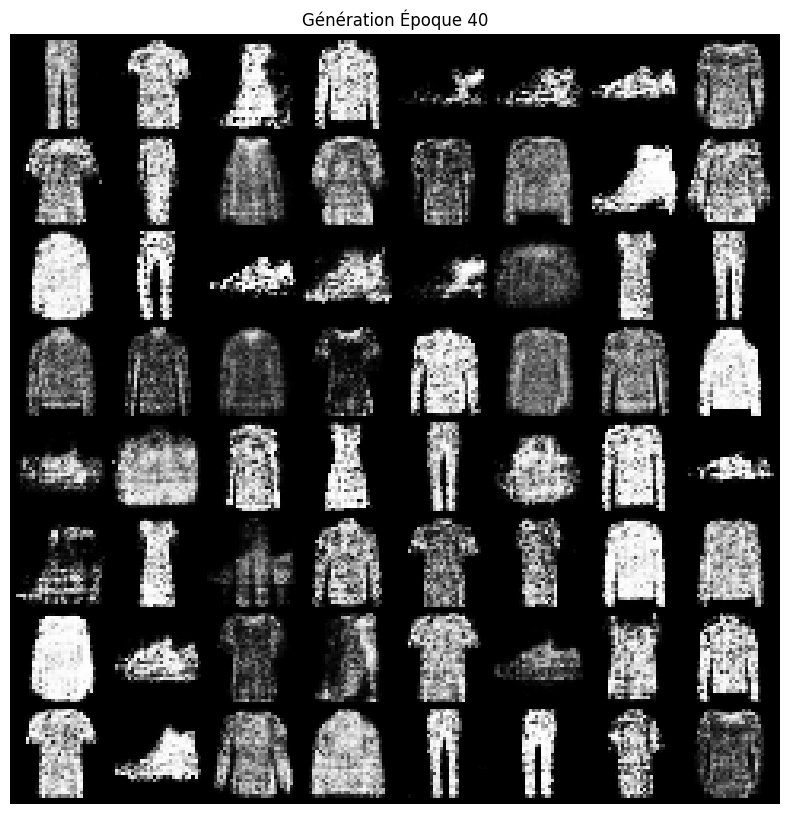

Epoch 41 | D Loss: 1.2392 | G Loss: 0.9757
Epoch 42 | D Loss: 1.2336 | G Loss: 0.9782
Epoch 43 | D Loss: 1.2416 | G Loss: 0.9648
Epoch 44 | D Loss: 1.2351 | G Loss: 0.9757
Epoch 45 | D Loss: 1.2362 | G Loss: 0.9713


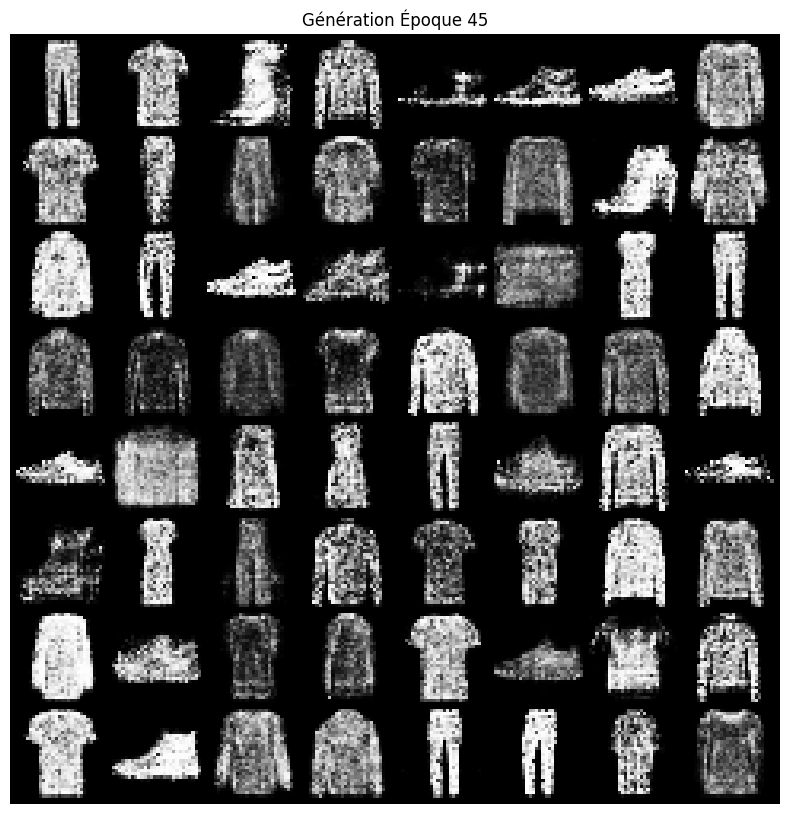

Epoch 46 | D Loss: 1.2373 | G Loss: 0.9664
Epoch 47 | D Loss: 1.2333 | G Loss: 0.9763
Epoch 48 | D Loss: 1.2351 | G Loss: 0.9731
Epoch 49 | D Loss: 1.2346 | G Loss: 0.9697
Epoch 50 | D Loss: 1.2340 | G Loss: 0.9695


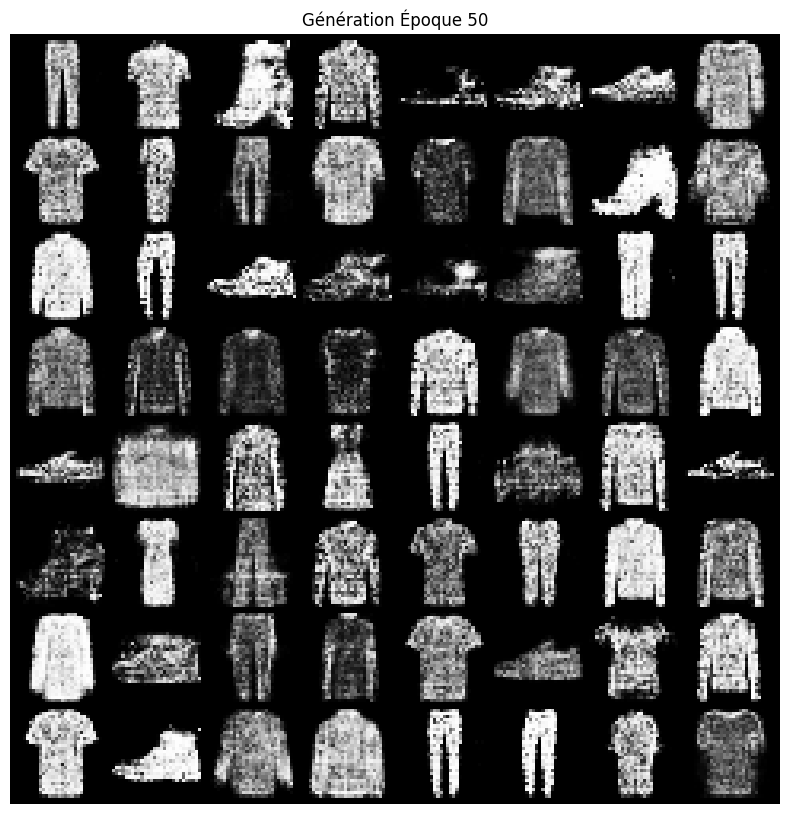

In [6]:
def train_gan(G, D, G_optimizer, D_optimizer, criterion, dataloader, epochs, latent_dim, device):
    G.train(); D.train()
    for epoch in trange(epochs, desc="Entraînement GAN"):
        #on initialise au début de chaque époque pour pouvoir accumuler les pertes de chaque batch,
        D_loss_total = 0
        G_loss_total = 0

        for real_images, _ in dataloader:

            # --- Préparation des données ---
            real_images = real_images.view(-1, image_size).to(device) #aplatir chaque image
            current_batch_size = real_images.size(0) #Récupérer la taille actuelle du batch

            # Tenseurs de cibles (VRAI=1.0, FAUX=0.0)
            # Utiliser des floats pour les cibles de BCE
            real_labels = torch.ones(current_batch_size, 1, device=device)
            fake_labels = torch.zeros(current_batch_size, 1, device=device)
            
            # 1a. Loss sur les images réelles (cible = 1)
            D_real_pred = D(real_images)
            D_real_loss = criterion(D_real_pred, real_labels)

            # 1b. Générer les fausses images et calculer la loss (cible = 0)
            noise = torch.randn(current_batch_size, latent_dim, device=device)
            fake_images = G(noise)

            # ⚠️ POINT CLÉ : .detach() pour arrêter la rétropropagation vers G
            D_fake_pred = D(fake_images.detach()) #On veut mettre à jour seulement les poids de D, pas ceux de G.
            D_fake_loss = criterion(D_fake_pred, fake_labels)

            # 1c. Rétropropagation de la loss totale de D
            D_loss = D_real_loss + D_fake_loss
            D_loss.backward() #rétropropagation
            D_optimizer.step() #mis à jour les poids

            D_loss_total += D_loss.item()

            # ===============================================
            # 2. ÉTAPE G : Améliorer le Générateur
            # ===============================================
            G_optimizer.zero_grad()

            # G veut que D prédise 1 (VRAI) pour ses fausses images (pour le tromper)
            # On réutilise fake_images, mais cette fois le graphe de G est attaché.
            G_pred = D(fake_images)
            G_loss = criterion(G_pred, real_labels) # ⚠️ CIBLE = 1 (real_labels) pour la loss de G

            G_loss.backward()
            G_optimizer.step()

            G_loss_total += G_loss.item()

        # --- Affichage de l'évolution (par époque) ---
        avg_D_loss = D_loss_total / len(dataloader)
        avg_G_loss = G_loss_total / len(dataloader)
        tqdm.write(f"Epoch {epoch+1:2d} | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f}")

        # 4. Visualisation toutes les 5 époques
        if (epoch + 1) % 5 == 0:
            G.eval()
            with torch.no_grad():
                # Générer 64 images à partir du bruit fixe
                generated_images = G(fixed_noise).cpu().view(64, 1, 28, 28)
                show_grid(make_grid(generated_images, 8), title=f"Génération Époque {epoch+1}")
            G.train()

train_gan(G, D, G_optimizer, D_optimizer, criterion, train_dataloader, epochs, latent_dim, device)

### Question  (Q3.1)

Dans l'étape d'entraînement du Discriminateur, nous utilisons `.detach()` sur les `fake_images` générées par $G$. Quel est l'effet précis de cette méthode PyTorch dans le contexte des GANs, et pourquoi est-il essentiel pour l'entraînement de $D$ ?

## Exercice : GAN sur CIFAR-10

**Objectif :**
Entraîner un GAN capable de générer des images couleur 32×32 inspirées du dataset CIFAR-10.

---

### 1. Préparation des données

* Charger le dataset **CIFAR-10** (ensemble d’entraînement uniquement).
* Créer un `DataLoader` avec un `batch_size` adapté.

---

### 2. Modèles du GAN

* Définir un **Générateur** (G) qui prend un vecteur de bruit latent et produit une image de taille 3×32×32.
* Définir un **Discriminateur** (D) qui prend une image 3×32×32 et renvoie un score (réel/faux).

---

### 3. Fonction de perte et optimiseurs

* Choisir une **fonction de perte binaire** (par ex. BCE).
* Choisir un **optimiseur** pour (G) et un pour (D) (par ex. Adam) avec un faible learning rate.

---

### 4. Boucle d’entraînement du GAN

Pour chaque époque :

1. **Améliorer D**

   * Utiliser un batch d’images réelles de CIFAR-10.
   * Générer un batch d’images fausses avec (G) à partir de bruit.
   * Calculer la perte de (D) sur réelles (label = 1) et fausses (label = 0).
   * Mettre à jour les paramètres de (D).

2. **Améliorer G**

   * Générer un nouveau batch d’images avec (G).
   * Passer ces images dans (D).
   * Calculer la perte de (G) en forçant (D) à prédire **réel** (label = 1).
   * Mettre à jour les paramètres de (G).

3. Sauvegarder les pertes de (G) et (D) pour les tracer plus tard.

---

### 5. Visualisation

* À intervalles réguliers (par ex. toutes les 5 époques), générer un petit **grid d’images** avec (G) et les afficher.
* À la fin de l’entraînement, tracer les **courbes de pertes** de (G) et (D) en fonction des époques.

---



# 1. GAN (Generative Adversarial Network)

Le **GAN classique** utilise :

* un **Générateur** = réseau **MLP** (couches *Linear*)
* un **Discriminateur** = réseau **MLP** aussi
* données **aplaties en 1D**

  * ex : image 28×28 → vecteur 784

✔ Simple

✔ Fonctionne sur de petits datasets comme MNIST, FashionMNIST

❌ Très mauvais pour les images complexes (couleurs, textures, 32×32, 64×64…)

❌ Ne capture pas bien les structures spatiales

---

# **2. DCGAN (Deep Convolutional GAN)**

Le **DCGAN** ajoute des couches **convolutionnelles** :

### ▶ Générateur :

`ConvTranspose2d` pour agrandir l’image progressivement

* `BatchNorm2d`
* `ReLU`
* `Tanh` en sortie

### ▶ Discriminateur :

`Conv2d` pour extraire les caractéristiques

* `LeakyReLU`
* (souvent) `Dropout`
* pas de pooling (utilisation du stride)

✔ Capture la structure spatiale

✔ Génère des images beaucoup plus réalistes

✔ Très efficace sur CIFAR-10, CelebA, etc.

❌ Plus lourd, demande plus de GPU

---

# **3. Différence clé en une phrase**

> **GAN = MLP (réseau full connecté)**
> **DCGAN = CNN (réseau convolutionnel)**

---

# **4. Tableau comparatif**

| Critère                        | GAN classique            | DCGAN                            |
| ------------------------------ | ------------------------ | -------------------------------- |
| Type de réseau                 | MLP                      | CNN                              |
| Images traitées                | aplaties en 1D           | images 2D avec canaux            |
| Générateur                     | Linear → Linear → Linear | ConvTranspose2D                  |
| Discriminateur                 | Linear                   | Conv2D                           |
| Qualité des images             | basse                    | élevée                           |
| Convient à                     | MNIST, FashionMNIST      | CIFAR-10, CelebA, images couleur |
| Comprend la structure spatiale | ❌ Non                    | ✔ Oui                            |

---


# **Exercice : Implémentation d’un DCGAN sur CIFAR-10**

## **Objectif**

Entraîner un **DCGAN (Deep Convolutional GAN)** pour générer des images en couleur (**32×32×3**) inspirées du dataset **CIFAR-10**.

---

## **1. Chargement des données**

* Charger **CIFAR-10** via `torchvision.datasets`.
* Appliquer les transformations nécessaires :

  * conversion en tenseurs
  * normalisation dans l’intervalle **[-1, 1]**
* Créer un `DataLoader` avec un batch size choisi (ex. 128).

---

## **2. Construction du Générateur (G)**

Créer un générateur convolutionnel utilisant :

* `ConvTranspose2d` pour agrandir les images
* `BatchNorm2d`
* `ReLU`
* `Tanh` en sortie (obligatoire pour sortir dans [-1, 1])

Entrée : vecteur latent ( z )
Sortie : image 3×32×32

---

## **3. Construction du Discriminateur (D)**

Créer un discriminateur convolutionnel utilisant :

* `Conv2d` pour réduire l’image
* `LeakyReLU(0.2)`
* (optionnel) `Dropout`
* sortie finale linéaire (logit)

Entrée : image 3×32×32
Sortie : score réel/faux

---

## **4. Fonction de perte & optimiseurs**

* Utiliser une **perte binaire** (ex. `BCEWithLogitsLoss`).
* Utiliser **Adam** pour G et D avec des paramètres typiques :

  * `lr = 0.0002`
  * `betas = (0.5, 0.999)`

---

## **5. Boucle d'entraînement**

Pour chaque époque :

### Étape D :

1. Prendre un batch d’images réelles.
2. Générer des images fausses via G.
3. Calculer :

   * perte D sur images réelles (labels = 1)
   * perte D sur images fausses (labels = 0)
4. Additionner et mettre à jour D.

### Étape G :

1. Générer un nouveau batch d’images.
2. Passer ces images dans D.
3. Calculer la perte de G (labels = 1 pour tromper D).
4. Mettre à jour G.

---

## **6. Visualisation**

* Toutes les quelques époques, générer un **grid de 64 images** avec G.
* À la fin :

  * afficher la **courbe de pertes de G et D**
  * commenter la stabilité du modèle.

---
